In [1]:
!pip install optuna --quiet

In [2]:
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, Subset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import optuna

import psudsr

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
# Define normalized utterance directories
pre_norm = "PSUH/NR/pre/segment/normalized/"
post_norm = "PSUH/NR/post/segment/normalized/"
dc_norm = "PSUH/NR/dc/segment/normalized/"
directories = [pre_norm, post_norm, dc_norm]
# Create multi-class TensorDataset
PSUH_speakers, PSUH_paths, PSUH_labels, PSUH_ds = psudsr.create_tensor_dataset(directories, binary=True)
PSUH_ds[0][0].shape

An error occurred with 05pre_nr_10.wav: Error opening '05pre_nr_10.wav': System error.
An error occurred with 17post_nr_1.wav: Error opening '17post_nr_1.wav': System error.
An error occurred with 36dc_nr_3.wav: Error opening '36dc_nr_3.wav': System error.


torch.Size([1, 201, 219])

### Split into train / val / test datasets

In [4]:
import json

# Load previously created indices
with open('PSUH/train_indices_binary.json', 'r') as file:
    train_indices = json.load(file)

with open('PSUH/val_indices_binary.json', 'r') as file:
    val_indices = json.load(file)
    
with open('PSUH/test_indices_binary.json', 'r') as file:
    test_indices = json.load(file)

# Create subsets
train_dataset = Subset(PSUH_ds, train_indices)
val_dataset = Subset(PSUH_ds, val_indices)
test_dataset = Subset(PSUH_ds, test_indices)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
print(len(train_indices))
print(len(val_indices))
print(len(test_indices))

464
117
146


#### Create CNN model

In [6]:
class CNN(nn.Module):
    def __init__(self, l1=4, l2=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 25 * 27, l1)  # Adjust the dimensions based on the input size
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 2)  # 2 classes
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32 * 25 * 27)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after first fully connected layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout after second fully connected layer
        x = self.fc3(x)
        return x

# Example usage
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=21600, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [7]:
def objective(trial):
    # Hyperparameters to tune
    l1 = trial.suggest_int('l1', 2, 16)
    l2 = trial.suggest_int('l2', 2, 16)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    
    # Load dataset
    train_dataset = Subset(PSUH_ds, train_indices)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    model = CNN(l1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Training loop (10 epoch for simplicity)
    model.train()
    for epoch in range(10):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    return loss.item()

In [8]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print("Best Hyperparameters:", study.best_params)

[I 2024-11-21 21:27:48,676] A new study created in memory with name: no-name-08bf2978-f680-436d-a809-8a803b8892da
/opt/conda/lib/python3.11/site-packages/torch/autograd/graph.py:768: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 500: named symbol not found (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
[I 2024-11-21 21:27:59,807] Trial 0 finished with value: 0.7462115287780762 and parameters: {'l1': 13, 'l2': 5, 'lr': 0.0007381678685957661}. Best is trial 0 with value: 0.7462115287780762.
[I 2024-11-21 21:28:10,358] Trial 1 finished with value: 0.6764452457427979 and parameters: {'l1': 2, 'l2': 16, 'lr': 2.2632492640136807e-05}. Best is trial 1 with value: 0.6764452457427979.
[I 2024-11-21 21:28:21,418] Trial 2 finished with value: 

Best Hyperparameters: {'l1': 14, 'l2': 13, 'lr': 0.0002534452979193049}


In [12]:
model = CNN(l1=14, l2=13)
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=21600, out_features=14, bias=True)
  (fc2): Linear(in_features=14, out_features=13, bias=True)
  (fc3): Linear(in_features=13, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Epoch 1/30, Training Loss: 0.59926, Validation Loss: 0.54619, Training Accuracy: 80.388%, Validation Accuracy: 82.051%
Epoch 2/30, Training Loss: 0.56484, Validation Loss: 0.51244, Training Accuracy: 79.095%, Validation Accuracy: 82.051%
Epoch 3/30, Training Loss: 0.55028, Validation Loss: 0.49727, Training Accuracy: 79.526%, Validation Accuracy: 82.051%
Epoch 4/30, Training Loss: 0.53527, Validation Loss: 0.5009, Training Accuracy: 80.388%, Validation Accuracy: 82.051%
Epoch 5/30, Training Loss: 0.54115, Validation Loss: 0.50785, Training Accuracy: 81.034%, Validation Accuracy: 82.051%
Epoch 6/30, Training Loss: 0.52417, Validation Loss: 0.48638, Training Accuracy: 81.034%, Validation Accuracy: 82.051%
Epoch 7/30, Training Loss: 0.52455, Validation Loss: 0.49604, Training Accuracy: 81.681%, Validation Accuracy: 82.051%
Epoch 8/30, Training Loss: 0.54555, Validation Loss: 0.49156, Training Accuracy: 81.25%, Validation Accuracy: 82.051%
Epoch 9/30, Training Loss: 0.51851, Validation Los

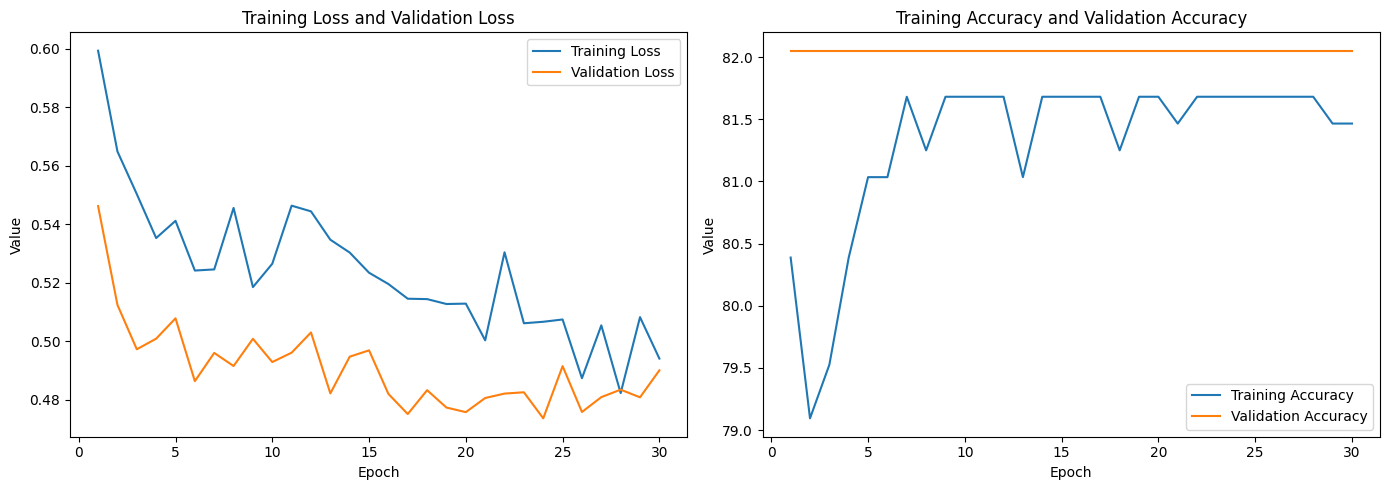

In [13]:
# Set loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00025)

# Initialize lists to store loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 30

for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * train_correct / train_total)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * val_correct / val_total)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {(running_loss/len(train_loader)):.5g}, Validation Loss: {(val_loss/len(val_loader)):.5g}, Training Accuracy: {(100 * train_correct / train_total):.5g}%, Validation Accuracy: {(100 * val_correct / val_total):.5g}%')

# Plotting the results
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
def evaluate_dataset(dataset_loader, model=model):
    model.eval()
    
    correct = 0
    total = 0
    incorrect_idx_dataset = []
    correct_idx_dataset = []
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():  # No need to track gradients
        for batch_idx, (inputs, labels) in enumerate(dataset_loader):
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
            # Collect correct and incorrect indices
            for i, (pred, label) in enumerate(zip(predicted, labels)):
                if pred == label:
                    correct_idx_dataset.append(batch_idx * dataset_loader.batch_size + i)
                else:
                    incorrect_idx_dataset.append(batch_idx * dataset_loader.batch_size + i)
                # Append to true and predicted labels list
                true_labels.append(label.item())
                pred_labels.append(pred.item())
                
    accuracy = 100 * correct / total
    print(f'Accuracy on dataset: {accuracy:.2f}%')
    return correct_idx_dataset, incorrect_idx_dataset, pred_labels, true_labels

In [15]:
correct_idx_train, incorrect_idx_train, pred_labels_train, true_labels_train = evaluate_dataset(train_loader)

Accuracy on dataset: 81.68%


In [16]:
correct_idx_val, incorrect_idx_val, pred_labels_val, true_labels_val = evaluate_dataset(val_loader)

Accuracy on dataset: 82.05%


In [17]:
correct_idx_test, incorrect_idx_test, pred_labels_test, true_labels_test = evaluate_dataset(test_loader)

Accuracy on dataset: 81.51%


In [18]:
# Identify which audio files are classified correctly/incorrectly using the original dataset indices
train_indices_correct = [train_indices[i] for i in correct_idx_train]
train_indices_incorrect = [train_indices[i] for i in incorrect_idx_train]
val_indices_correct = [val_indices[i] for i in correct_idx_val]
val_indices_incorrect = [val_indices[i] for i in incorrect_idx_val]
test_indices_correct = [test_indices[i] for i in correct_idx_test]
test_indices_incorrect = [test_indices[i] for i in incorrect_idx_test]

In [19]:
# Group all correct/incorrect indices together 
all_correct = train_indices_correct + val_indices_correct + test_indices_correct
all_incorrect = train_indices_incorrect + val_indices_incorrect + test_indices_incorrect
# Sort indices
all_correct.sort()
all_incorrect.sort()

In [20]:
print(len(all_correct))
print(len(all_incorrect))

594
133


In [21]:
# Get corresponding filenames for correct/incorrect indices
correct_files = [PSUH_paths[i] for i in all_correct]
incorrect_files = [PSUH_paths[i] for i in all_incorrect]
# Sort indices
correct_files.sort()
incorrect_files.sort()

In [22]:
utterances_correct = psudsr.summarize_list(correct_files)
utterances_incorrect = psudsr.summarize_list(incorrect_files)

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd


def evaluate_labels(true_labels, predicted_labels, title):
    labels = ['healthy', 'dysarthric']
    # Create confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.title("Confusion Matrix: " + title)
    plt.show()
    print(classification_report(true_labels, predicted_labels))

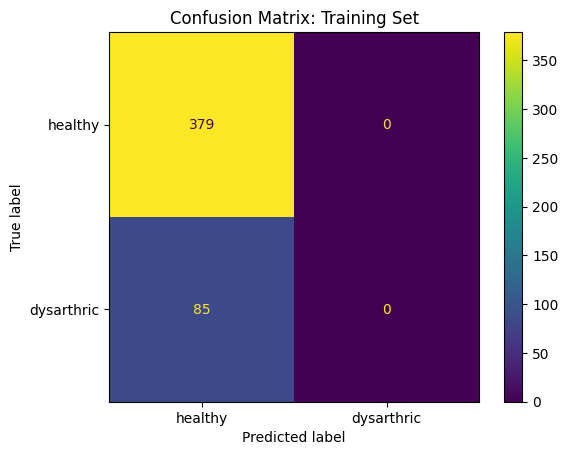

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       379
           1       0.00      0.00      0.00        85

    accuracy                           0.82       464
   macro avg       0.41      0.50      0.45       464
weighted avg       0.67      0.82      0.73       464



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
evaluate_labels(true_labels_train, pred_labels_train, 'Training Set')

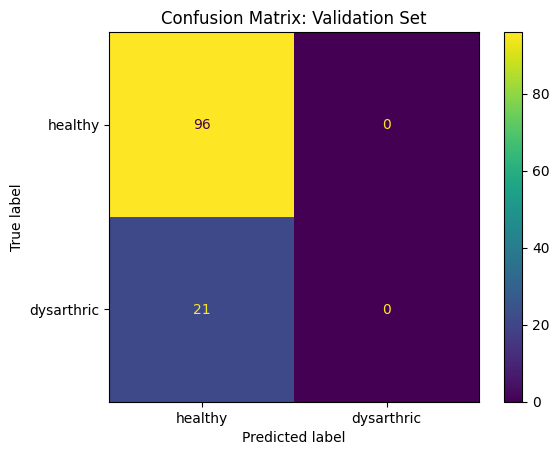

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        96
           1       0.00      0.00      0.00        21

    accuracy                           0.82       117
   macro avg       0.41      0.50      0.45       117
weighted avg       0.67      0.82      0.74       117



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
evaluate_labels(true_labels_val, pred_labels_val, 'Validation Set')

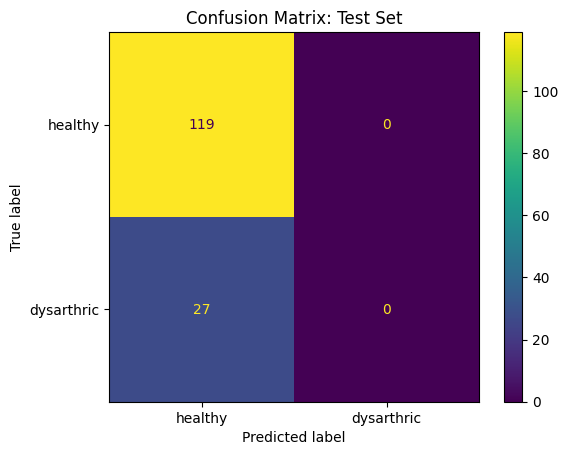

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       119
           1       0.00      0.00      0.00        27

    accuracy                           0.82       146
   macro avg       0.41      0.50      0.45       146
weighted avg       0.66      0.82      0.73       146



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
evaluate_labels(true_labels_test, pred_labels_test, 'Test Set')